# Turing JL

## Turing Tutorials

# 3. Bayesian Linear Regression

**TuringLang contributors**

**Source:** https://turing.ml/dev/tutorials/05-linear-regression/

In this notebook we learn how to use `Turing.jl` to do implement Bayesian linear regression.


In [4]:
using Turing
using Distributions
using DataFrames
using RDatasets
using MCMCChains
using MLDataUtils: shuffleobs, splitobs, rescale!
using Plots
using StatsPlots
using Distances
using Random

Random.seed!(0)

# Hide the progress prompt while sampling.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/josinai/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/josinai/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


We will use the mtcars dataset from the RDatasets package. mtcars contains a variety of statistics on different car models, including their miles per gallon, number of cylinders, and horsepower, among others.

We want to know if we can construct a Bayesian linear regression model to predict the miles per gallon of a car, given the other statistics it has.

In [2]:
data = RDatasets.dataset("datasets", "mtcars");

first(data, 6)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/josinai/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/josinai/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [3]:
size(data)

(32, 12)

We'll split the dataset into train and test subsets, then we will separate the target variable (`MPG`) and standardize the rest of the feature variables.

In [5]:
# Remove the model column which is non-numeric and only adds noise
select!(data, Not(:Model))

# Split the dataset 70%/30% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.7)

# Convert the data into a matrix
target = :MPG
X_train, y_train = Matrix(select(trainset, Not(target))), trainset[:, target]
X_test, y_test = Matrix(select(testset, Not(target))), testset[:, target]

# Standardize the features variables
μ, σ = rescale!(X_train; obsdim = 1)
rescale!(X_test, μ, σ; obsdim = 1)

# Standardize the target variable.
μtarget, σtarget = rescale!(y_train; obsdim = 1)
rescale!(y_test, μtarget, σtarget; obsdim = 1);


### Bayesian Linear Model

In a traditional linear model using OLS, the model looks like:

$$y_i = \alpha + \beta^T X_i$$

whereas in a Bayesian model we will learn the location of a Gaussian distribution:

$$y_i \sim \mathscr{N}(\alpha + \beta^T X_i, \sigma^2)$$

where $\sigma^2$ is the common variance across all samples. We will assign $\sigma^2$ a prior of a _half Normal_ over positive support. We'll assume that the intercept $\alpha$ has Normal prior but with a relatively high variance to indicate our assumption that MPG can be explained by the feature variables, but that there is uncertainty. Finally the coefficients $\beta$ will have a multivariate normal prior with a high variance of 10. In other words:

$$\sigma^2 \sim \mathscr{N}_{+}(0, 100)$$
$$\alpha \sim \mathscr{N}(0, \sqrt{3})$$
$$\beta \sim \mathscr{N}_{d}(0, \sqrt{10}),$$

where $d$ is the number of feature variables, in this case 10.

In [8]:
@model function bayesian_linear_regression(x, y)
    d = size(x, 2)
    
    σ² ~ truncated(Normal(0, 100), 0, Inf)
    α ~ Normal(0, sqrt(3))
    β ~ MvNormal(d, sqrt(10))
    
    # Calculate all the mu terms.
    μ = α .+ x * β
    y ~ MvNormal(μ, sqrt(σ²))
end

bayesian_linear_regression (generic function with 1 method)

Now let's use the No U-Turn (NUTS) Hamiltonian Monte Carlo sampler:

In [10]:
model = bayesian_linear_regression(X_train, y_train)
chain = sample(model, NUTS(0.65), 3_000);

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/josinai/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188


As a visual check to confirm that our coefficients have converged, we plot the densities and trace plots for our parameters:

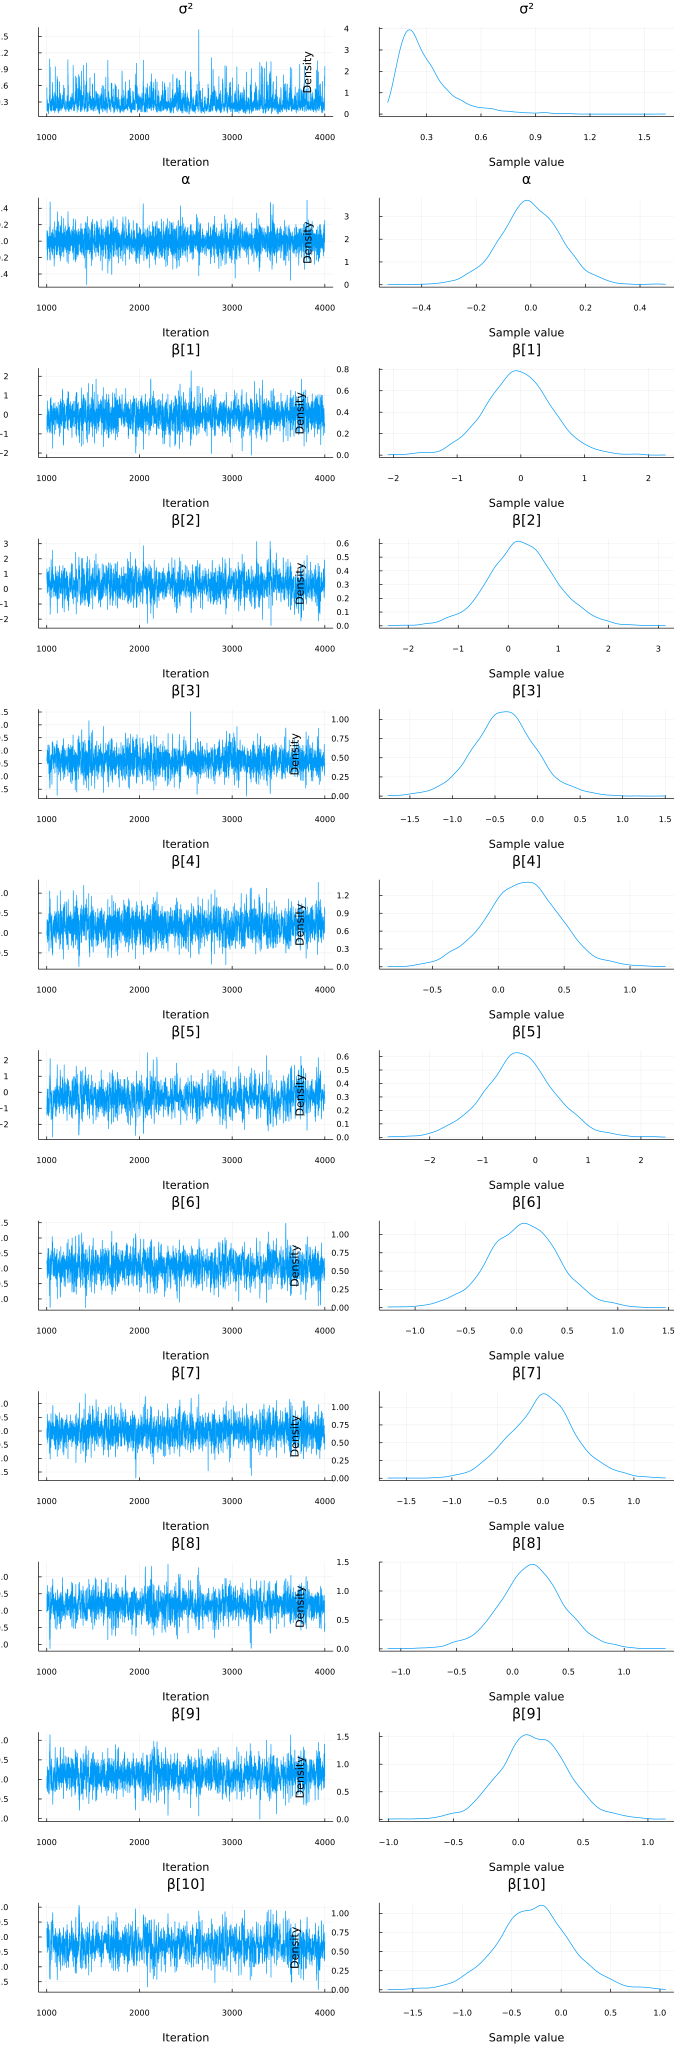

In [11]:
plot(chain)

Notice that in the end the variance for each coefficient tends to be lower than 10 and the mean is not necessarily zero, show how our prior beliefs, which were fairly uncertain, have been updated to something more certain in the posterior.

### Comparison with OLS

A satisfactory test of our model is to evaluate how well it predicts. Importantly, we want to compare our model to existing tools like OLS. The code below uses the `GLM.jl` package to generate a traditional OLS multiple regression model on the same data as our probabilistic model.

In [13]:
using GLM

# Perform multiple regression OLS.
train_with_intercept = hcat(ones(size(X_train, 1)), X_train)
ols = lm(train_with_intercept, y_train)

# Compute predictions on the training data set
# and unstandardize them.
p = GLM.predict(ols)
train_prediction_ols = μtarget .+ σtarget .* p

# Compute predictions on the test data set
# and unstandardize them.
test_with_intercept = hcat(ones(size(X_test, 1)), X_test)
p = GLM.predict(ols, test_with_intercept)
test_prediction_ols = μtarget .+ σtarget .* p;

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1342


### Bayesin predictions

To make predictions in the Bayesian model we use the posterior distribution to sample the optimal parameters and then draw samples of the target variable:

In [14]:
# Make a prediction given an input vector.
function predict(chain, X)
    p = get_params(chain[200:end, :, :])
    y = p.α' .+ X * reduce(hcat, p.β)'
    return vec(mean(y; dims = 2))
end

predict (generic function with 1 method)

In [16]:
# Calculate the predictions for the training and testing sets
# and unstandardize them.
p = predict(chain, X_train)
train_prediction_bayes = μtarget .+ σtarget .* p
p = predict(chain, X_test)
test_prediction_bayes = μtarget .+ σtarget .* p

# Show the predictions on the test data set.
DataFrame(
    MPG = testset[!, target],
    Bayes = test_prediction_bayes,
    OLS = test_prediction_ols
)

,MPG,Bayes,OLS
,Float64,Float64,Float64
1,19.2,18.0626,18.1265
2,15.0,6.56522,6.37891
3,16.4,13.954,13.883
4,14.3,11.8185,11.7337
5,21.4,25.1723,25.1916
6,18.1,20.6272,20.672
7,19.7,15.9669,15.8408
8,15.2,18.349,18.3391
9,26.0,28.4809,28.4865


Now let's evaluate the loss using the mean squared error:

$$ MSE = \frac{1}{n}\sum_{i=1}^{n}(\hat{y}_i - y_i)^2. $$

In [17]:
println(
    "Training set:",
    "\n\tBayes loss: ",
    msd(train_prediction_bayes, trainset[!, target]),
    "\n\tOLS loss: ",
    msd(train_prediction_ols, trainset[!, target])
)

println(
    "Test set:",
    "\n\tBayes loss: ",
    msd(test_prediction_bayes, testset[!, target]),
    "\n\tOLS loss: ",
    msd(test_prediction_ols, testset[!, target])
)

Training set:
	Bayes loss: 4.6507680921950625
	OLS loss: 4.648142085690515
Test set:
	Bayes loss: 14.239279228546044
	OLS loss: 14.79684777905157


So we see that even though both models had close scores on the training dataset, the Bayesian model generalized slightly better on the test data.